In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from collections import defaultdict
import yfinance as yf


In [ ]:
# read the csv file by selecting the path
path_file = "D:/Dropbox/Pastor/data/crypto-active_5min/BTC_5min.txt"
btc = pd.read_csv(path_file, header = None, sep = ",", names = ["Date", "Open", "High", "Low", "Close", "Volume"])
btc["Date"] = pd.to_datetime(btc['Date'])
btc.set_index('Date', inplace=True)

# set a dictionary with the variables and functions to create daily bars
ohlcv_dict = {'Open':'first', 'High':'max', 'Low':'min', 'Close': 'last', 'Volume':'sum'}

btc = btc.resample('1440Min').apply(ohlcv_dict).dropna()
btc.head()


In [67]:
#returns_spy

stock_data = pd.merge(btc, returns_spy, right_index=True, left_index=True ).sort_index()
stock_data.columns = ["Open", "High", "Low", "Close", "Volume", "returns_spy"]
returns = pd.DataFrame({
                        'stocks': stock_data['Close'].rolling(window=2, center=False).apply(lambda x: x[1] / x[0] - 1),
                        'tbills': (stock_data['returns_spy']),
                                    }, index=stock_data.index).dropna()


In [29]:
class QTrader():


    def __init__(self, btc, returns_spy):

        self.btc = btc
        self.returns_spy = returns_spy

        #btc = yf.download(tickers="BTC", auto_adjust = True)
        #spy = yf.download(tickers="SPY", auto_adjust=True)
       
      
        self.stock_data = pd.merge(self.btc, self.returns_spy, right_index=True, left_index=True ).sort_index()
        self.stock_data.columns = ["Open", "High", "Low", "Close", "Volume", "returns_spy"]
        self.returns = pd.DataFrame({
                        'stocks': self.stock_data['Close'].rolling(window=2, center=False).apply(lambda x: x[1] / x[0] - 1),
                        'spy': (self.stock_data['returns_spy']),
                                    }, index=self.stock_data.index).dropna()

        self.returns['risk_adjusted'] = self.returns.stocks - self.returns.spy

        self.returns['risk_adjusted_moving'] = self.returns.risk_adjusted.rolling(window=12).apply(lambda x: x.mean())
        self.returns['risk_adjusted_stedv'] = self.returns.risk_adjusted.rolling(window=12).apply(lambda x: x.std())
        self.returns['risk_adjusted_high']  = self.returns.risk_adjusted_moving + 1.5 * self.returns.risk_adjusted_stedv
        self.returns['risk_adjusted_low'] = self.returns.risk_adjusted_moving - 1.5 * self.returns.risk_adjusted_stedv
        
        self.returns['state'] = (self.returns.risk_adjusted > self.returns.risk_adjusted_high).astype('int') - \
                                (self.returns.risk_adjusted < self.returns.risk_adjusted_low).astype('int')

        # 12 weeks of data
        # what's the high average
        # what's the low average
        # if the return is higher than the average high -> 1
        # if the return is lower than the average low -> -1

    def buy_and_hold(self, dates):
        return pd.Series(1, index = dates)

    def buy_spy(self, dates):
        return pd.Series(0, index = dates)

    def random(self, dates):
        return pd.Series(np.random.randint(-1, 2, size = len(dates)), index = dates)

    def calc_returns(self, holdings):
        return pd.Series(self.returns.spy + holdings * self.returns.risk_adjusted, index=holdings.index)

    def evaluate(self, holdings):
        return pd.Series(self.calc_returns(holdings) + 1).cumprod()

    def q_holdings(self, training_indexes, testing_indexes):
        factors = pd.DataFrame({'action': 0, 'reward': 0, 'state':0}, index = training_indexes)     

        # value Iteration
        # Q-Learning
        # iterating on State, Action, Reward, and State prime
        q = {0: {1:0, 0:0, -1:0}}

        # Learning Q is expensive
        # Dyna
        T = np.zeros((3, 3, 3)) + 0.0001
        R = np.zeros((3, 3))
        #Learn Q 
        # Update a model Transitions and also Rewards
        # "Hallucinate"



        for i in range(100): # this loop iterates 100 times or until convergence is reach over the training data 
            last_row, last_date = None, None

            for date, row in factors.iterrows():
                return_data = self.returns.loc[date]

                if return_data.state not in q:
                    q[return_data.state] = {1:0, 0:0, -1:0}

                if last_row is None or np.isnan(return_data.state):
                    state = 0
                    reward = 0
                    action = 0

                else:
                    state = int(return_data.state)

                    # we add randomness to the state every 0.1% of the time
                    if random.random() > 0.001:
                        action = max(q[state], key=q[state].get)
                    else:
                        action = random.randint(-1, 1)

                    reward = last_row.action * (return_data.stocks - return_data.spy)

                    factors.loc[date, 'reward'] = reward
                    factors.loc[date, 'action'] = action
                    factors.loc[date, 'state'] = return_data.state

                    alpha = 0.01 # can be customize, so you can try 0.0001 if you want
                    discount = 0.9

                    update = alpha * (factors.loc[date, 'reward'] + discount * max(q[row.state].values()) - q[state][action])

                    if not np.isnan(update):
                        q[state][action] += update

                    # Dyna
                    action_idx = int(last_row.action + 1)
                    state_idx = int(last_row.state + 1)
                    new_state_idx = int(state + 1)

                    T[state_idx][action_idx][state_idx] += 1

                    R[state_idx][action_idx] = (1-alpha) * R[state_idx][action_idx] + alpha * reward


                    
                last_date, last_row = date, factors.loc[date]

            for j in range(100):
                state_idx = random.randint(0, 2)
                action_idx = random.randint(0, 2)
                new_state = np.random.choice([-1, 0, 1], 1, p=T[state_idx][action_idx]/T[state_idx][action_idx].sum())[0]

                r = R[state_idx][action_idx]
                q[state][action] += alpha * (r + discount * max(q[new_state].values()) - q[state][action])

            sharpe = self.sharpe(factors.action)

            if sharpe > 1.20:
                break

            print(f'For episode {i} we get an internal sharpe ratio of {self.sharpe(factors.action)}')

        testing = pd.DataFrame({'action': 0, 'state': 0}, index = testing_indexes)
        testing['state'] = self.returns.loc[testing_indexes, 'state']
        testing['action'] = testing['state'].apply(lambda state: max(q[state], key = q[state].get))

        return testing.action

    def sharpe(self, holdings):
        returns = holdings * (self.returns.stocks - self.returns.spy)
        return np.nanmean(returns) / np.nanstd(returns)

    def results_trades(self, buy_or_evaluate):

        midpoint = int(len(self.returns.index) / 2)
        training_indexes = self.returns.index[:midpoint]
        testing_indexes = self.returns.index[midpoint:]

        self.portfolios = pd.DataFrame({'buy_and_hold': self.buy_and_hold(testing_indexes),
                                    'buy_spy':     self.buy_spy(testing_indexes),
                                   'random':       self.random(testing_indexes),
                                   'qtrader':      self.q_holdings(training_indexes, testing_indexes)
                                    }, index=testing_indexes)

        self.portfolio_values = pd.DataFrame({
            'buy_and_hold':     self.evaluate(self.portfolios.buy_and_hold),
            'buy_spy':          self.evaluate(self.portfolios.buy_spy),
            'random':           self.evaluate(self.portfolios.random),
            'qtrader':          self.evaluate(self.portfolios.qtrader)
        }, index=testing_indexes)  

        if buy_or_evaluate == "buy":
            return self.portfolios
        elif buy_or_evaluate == "evaluate":
            return self.portfolio_values


      
    def graph_portfolios(self):
        midpoint = int(len(self.returns.index) / 2)
        training_indexes = self.returns.index[:midpoint]
        testing_indexes = self.returns.index[midpoint:]

        portfolios = pd.DataFrame({'buy_and_hold': self.buy_and_hold(testing_indexes),
                                    'buy_spy':     self.buy_spy(testing_indexes),
                                   'random':       self.random(testing_indexes),
                                   'qtrader':      self.q_holdings(training_indexes, testing_indexes)
                                    }, index=testing_indexes)

        portfolio_values = pd.DataFrame({
            'buy_and_hold':     self.evaluate(portfolios.buy_and_hold),
            'buy_spy':          self.evaluate(portfolios.buy_spy),
            'random':           self.evaluate(portfolios.random),
            'qtrader':          self.evaluate(portfolios.qtrader)
        }, index=testing_indexes)

        portfolio_values.plot()

        plt.annotate('Buy and Hold sharpe ratio: {} \n QTrader: {}'.format(self.sharpe(portfolios.buy_and_hold), self.sharpe(portfolios.qtrader)), xy=(0.25, 0.95),
        xycoords="axes fraction")

        plt.show()


    

In [30]:
# set a dictionary with the variables and functions to create daily bars
ohlcv_dict = {'Open':'first', 'High':'max', 'Low':'min', 'Close': 'last', 'Volume':'sum'}

#path_file = "D:/Dropbox/Pastor/data/crypto-active_5min/BTC_5min.txt"
#btc = pd.read_csv(path_file, header = None, sep = ",", names = ["Date", "Open", "High", "Low", "Close", "Volume"])
path_file_es = "D:/Dropbox/Pastor/data/futures_unadjusted_5/ES_continuous_UNadjusted_5min.txt"
spy = pd.read_csv(path_file_es, header = None, sep = ",", names = ["Date", "Open", "High", "Low", "Close", "Volume"])
spy["Date"] = pd.to_datetime(spy['Date'])
spy.set_index('Date', inplace=True)
spy = spy.resample('1440Min').apply(ohlcv_dict).dropna()
returns_spy = spy.Close.pct_change().dropna()


path_file_nq = "D:/Dropbox/Pastor/data/futures_unadjusted_5/NQ_continuous_UNadjusted_5min.txt"
btc = pd.read_csv(path_file_nq, header = None, sep = ",", names = ["Date", "Open", "High", "Low", "Close", "Volume"])
btc["Date"] = pd.to_datetime(btc['Date'])             
btc.set_index('Date', inplace=True)
btc = btc.resample('1440Min').apply(ohlcv_dict).dropna()


q = QTrader(btc, returns_spy)


In [ ]:
def get_data(test_stock, free_risk):
    test_stock = test_stock.upper()
    free_risk = free_risk.upper()

    btc = yf.download(tickers=test_stock, auto_adjust = True)
    spy = yf.download(tickers=free_risk, auto_adjust=True)

In [33]:
trades = q.results_trades("buy")

For episode 0 we get an internal sharpe ratio of -0.005110271201562112


C:\Users\Pastor\AppData\Local\Temp/ipykernel_5016/136452210.py:142: RuntimeWarning: invalid value encountered in double_scalars
  return np.nanmean(returns) / np.nanstd(returns)


For episode 1 we get an internal sharpe ratio of nan
For episode 2 we get an internal sharpe ratio of -0.010217224389602155
For episode 3 we get an internal sharpe ratio of 0.03701421404209494
For episode 4 we get an internal sharpe ratio of -0.037325847379525726
For episode 5 we get an internal sharpe ratio of 0.01992573881112292
For episode 6 we get an internal sharpe ratio of 0.10076631208427352


For episode 0 we get an internal sharpe ratio of 0.09711857379860205


C:\Users\Pastor\AppData\Local\Temp/ipykernel_5016/136452210.py:142: RuntimeWarning: invalid value encountered in double_scalars
  return np.nanmean(returns) / np.nanstd(returns)


For episode 1 we get an internal sharpe ratio of nan


C:\Users\Pastor\AppData\Local\Temp/ipykernel_5016/136452210.py:142: RuntimeWarning: invalid value encountered in double_scalars
  return np.nanmean(returns) / np.nanstd(returns)


For episode 2 we get an internal sharpe ratio of nan
For episode 3 we get an internal sharpe ratio of 0.030493418932937277
For episode 4 we get an internal sharpe ratio of 0.17574041951883274
For episode 5 we get an internal sharpe ratio of 0.13535154280478404


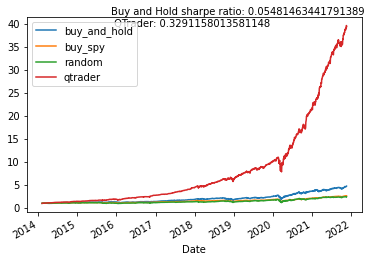

In [32]:
q.graph_portfolios()